In [1]:
# Install this to load the binary dataframe file
#
#!!pip install pickle-mixin

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pickle import Pickler, Unpickler

## Lendo os CSVs

In [56]:
# Method to load df
def get_samples(name):
    df = Unpickler(open('./' + name, 'rb')).load()
    return df

In [57]:
df = get_samples('df_10_16.sav')
df.head()

,DATA,FURTO,ROUBO,HOMICÍDIO,LESAO CORPORAL,ESTUPRO,TRÁFICO
0,2010-01-01,33356.0,54358.0,2592.0,28608.0,1648.0,3104.0
1,2010-02-01,30819.0,51905.0,2330.0,27317.0,1461.0,3159.0
2,2010-03-01,35983.0,59073.0,2566.0,30810.0,1411.0,3529.0
3,2010-04-01,33948.0,56141.0,2458.0,28741.0,1293.0,3257.0
4,2010-05-01,36222.0,58404.0,2431.0,29500.0,1425.0,3403.0


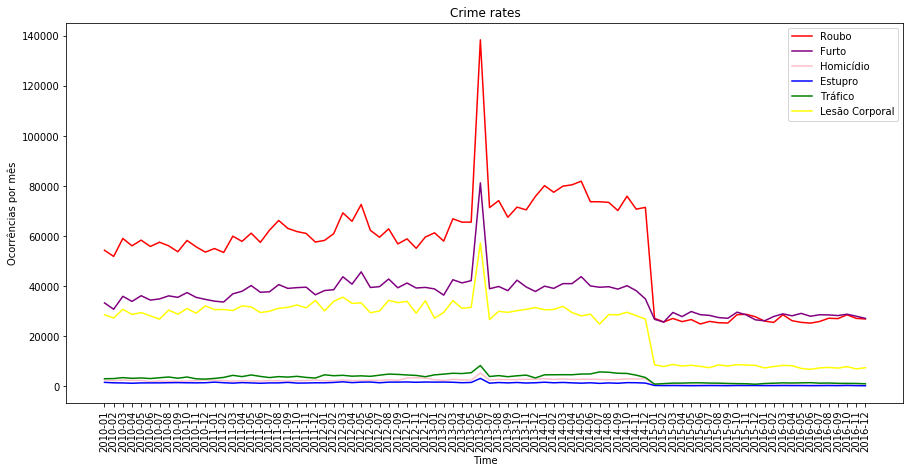

In [10]:
plt.figure(figsize=(15,7))
plt.plot(df['ROUBO'], color = 'red', label = 'Roubo')
plt.plot(df['FURTO'], color = 'purple', label = 'Furto')
plt.plot(df['HOMICÍDIO'], color = 'pink', label = 'Homicídio')
plt.plot(df['ESTUPRO'], color = 'blue', label = 'Estupro')
plt.plot(df['TRÁFICO'], color = 'green', label = 'Tráfico')
plt.plot(df['LESAO CORPORAL'], color = 'yellow', label = 'Lesão Corporal')
plt.title('Crime rates')
plt.xlabel('Time')
plt.xticks(np.arange(84), df['DATA'].map(lambda x: x.strftime('%Y-%m')), rotation=90)
plt.ylabel('Ocorrências por mês')
plt.legend()
plt.show()

# Separando dataset de treino e teste

In [96]:
testing_complete = df[df['DATA'] >= pd.to_datetime('20160101', format='%Y%m%d', errors='ignore')]
testing_processed = testing_complete.iloc[:, 3:4].values
training_complete = df[df['DATA'] < pd.to_datetime('20160101', format='%Y%m%d', errors='ignore')]
training_processed = training_complete.iloc[:, 3:4].values

In [97]:
testing_processed

array([[430.],
       [424.],
       [463.],
       [481.],
       [411.],
       [350.],
       [414.],
       [429.],
       [439.],
       [469.],
       [387.],
       [502.]])

In [98]:
from sklearn.preprocessing import MinMaxScaler  
scaler = MinMaxScaler(feature_range = (0, 1))

training_scaled = scaler.fit_transform(training_processed) 

In [99]:
# Usando um time step de 12 meses
# nesta rede, 12 observaçoes servem de feature e o 13 é o "label"

features_set = []  
labels = []  
for i in range(12, len(training_scaled)):  
    features_set.append(training_scaled[i-12:i, 0])
    labels.append(training_scaled[i, 0])

#Convertendo features e labels em numpy arrays
features_set, labels = np.array(features_set), np.array(labels)

# Convertendo dado para o a dimensionalidade adequada para o LSTM
# # dimensoes: 1ª = nº de observações, 2ª = nº de time steps(12), 3ª = nº de indicadores (features) (1)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))  

In [100]:
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout  

In [101]:
model = Sequential() 
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  
model.add(Dropout(0.2))

# como há apenas um output, aqui temos units=1
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [102]:
model.fit(features_set, labels, epochs = 100, batch_size = 32)

Epoch 1/100
60/60 [==============================] - 5s 81ms/step - loss: 0.1711
Epoch 2/100
60/60 [==============================] - 0s 1ms/step - loss: 0.1272
Epoch 3/100
60/60 [==============================] - 0s 1ms/step - loss: 0.0865
Epoch 4/100
60/60 [==============================] - 0s 1ms/step - loss: 0.0516
Epoch 5/100
60/60 [==============================] - 0s 1ms/step - loss: 0.0387
Epoch 6/100
60/60 [==============================] - 0s 1ms/step - loss: 0.0608
Epoch 7/100
60/60 [==============================] - 0s 1ms/step - loss: 0.0521
Epoch 8/100
60/60 [==============================] - 0s 1ms/step - loss: 0.0354
Epoch 9/100
60/60 [==============================] - 0s 1ms/step - loss: 0.0377
Epoch 10/100
60/60 [==============================] - 0s 1ms/step - loss: 0.0439
Epoch 11/100
60/60 [==============================] - 0s 1ms/step - loss: 0.0452
Epoch 12/100
60/60 [==============================] - 0s 1ms/step - loss: 0.0391
Epoch 13/100
60/60 [================

In [103]:
### Ajustando dados de teste
# para pegarmos os dados dos 12 meses anteriores ao teste, precisamos do dataset original
total = pd.concat((training_complete['HOMICÍDIO'], testing_complete['HOMICÍDIO']), axis=0)

test_inputs = total[len(total) - len(testing_complete) - 12:].values
test_inputs = test_inputs.reshape(-1,1)  
test_inputs = scaler.transform(test_inputs)


test_features = []  
for i in range(12, 24):  
    test_features.append(test_inputs[i-12:i, 0])

test_features = np.array(test_features) 
# Convertendo dado para o a dimensionalidade adequada para o LSTM
# # dimensoes: 1ª = nº de observações, 2ª = nº de time steps(12), 3ª = nº de indicadores (features) (1)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))  

In [104]:
predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)  

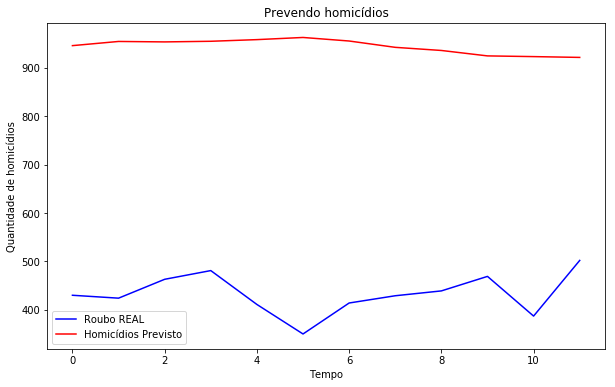

In [106]:
plt.figure(figsize=(10,6))  
plt.plot(testing_processed, color='blue', label='Roubo REAL')  
plt.plot(predictions , color='red', label='Homicídios Previsto')  
plt.title('Prevendo homicídios')  
plt.xlabel('Tempo')  
plt.ylabel('Quantidade de homicídios')  
plt.legend()  
plt.show()  